Get metrics under the `all_lab` folder under runs.

The results of different split is under the checkpoint.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from ast import literal_eval
from typing import List
import re
import importlib

import context
os.chdir(context.proj_dir)

import cont_gen.utils
importlib.reload(cont_gen.utils)
import cont_gen.evaluate.cal_metrics
importlib.reload(cont_gen.evaluate.cal_metrics)
from cont_gen.utils import load_jsonl, save_jsonl, plot_multiple_loss, get_loss_df_norm,get_ckpt_paths, load_json, save_json
from cont_gen.evaluate.cal_metrics import cal_collective_point_metrics, get_point_counts, get_doc_metrics, get_overall_metrics
import cont_gen.evaluate.io
importlib.reload(cont_gen.evaluate.io)
from cont_gen.evaluate.io import RunManager

## Get Evaluation Results

In [14]:
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}
def parse_pred(text: str):
    if text == 'No' or text == 'No.':
        return ''
    else:
        return text.removeprefix('Yes.')

def get_tk_name(path):
    if 't5' in path:
        tk_name = 'flan-t5'
    elif 'llama3' in path:
        tk_name = 'llama3'
    elif 'mistral' in path:
        tk_name = 'mistral'
    else:
        print(f'missing tk_name for {path}')
        tk_name = None
    return tk_name

def handle_model_runs(model_run):
    """Evaluate checkpoints of all model runs"""
    for exp_path in Path(model_run).glob('*'):
        print(f'Handle {str(exp_path)}')
        tk_name = get_tk_name(str(exp_path))
        for split in ['seed42_tr29', 'seed89_tr29', 'seed128_tr29']:
            print(split)
            for ckpt in get_ckpt_paths(exp_path):
                print(f'\t{ckpt.name}')
                test_meta_ood = pd.read_csv(f'data/ood_split/{split}/{tk_name}/test_meta_ood.csv', converters = cvt)
                cal_ckpt_metrics(ckpt / split, test_meta_ood, parse_pred)

def cal_ckpt_metrics(ckpt, ground_df, parse_fn):
    ckpt = Path(ckpt)
    if not ckpt.exists():
        return

    pred_sampled = ckpt / f'predictions_ood_sampled.jsonl'

    ov_sampled_path = ckpt / f'ov_metrics_ood_sampled.csv'
        
    
    if ov_sampled_path.exists():
        return
    pred_sampled_df = pd.DataFrame(load_jsonl(pred_sampled))
    ov_mets_sampled, detail_df_sampled = get_overall_metrics(ground_df, pred_sampled_df, parse_fn)
    save_json(ov_mets_sampled, ov_sampled_path)
    detail_df_sampled.to_csv(ckpt / f'detail_metrics_ood_sampled.csv', index = False)


In [19]:
handle_model_runs('runs/all_lab/mistral_chat')

Handle runs/all_lab/mistral_chat/pmt_01_lr1e-5_bs16_wd0.0
seed42_tr29
	checkpoint-26569
	checkpoint-53138
	checkpoint-79707
	checkpoint-106276
	checkpoint-132845
seed89_tr29
	checkpoint-26569
	checkpoint-53138
	checkpoint-79707
	checkpoint-106276
	checkpoint-132845
seed128_tr29
	checkpoint-26569
	checkpoint-53138
	checkpoint-79707
	checkpoint-106276
	checkpoint-132845


##  Load all results

In [27]:
def load_metrics_df(run_dir, fname):
    """Load all model results to checkpoints to dataframe"""
    # columns: model, split, ckpt, res_ov or res_detail
    lines = []
    for model_run in Path(run_dir).glob('*'):
        exp_run = list(model_run.glob('*'))[0]
        for ckpt_p in get_ckpt_paths(exp_run):
            for split_p in ckpt_p.glob('seed*'):
                # load the file
                if fname.startswith('ov'):
                    res = load_json(split_p / fname)
                else:
                    res = pd.read_csv(split_p / fname)
                lines.append((model_run.name, split_p.name, ckpt_p.name, res))
    return pd.DataFrame(lines, columns = ['model', 'split', 'ckpt', 'res_' + fname.split('_')[0]])
        

In [28]:
ov_all_ckpts = load_metrics_df('runs/all_lab', 'ov_metrics_ood_sampled.csv')

In [29]:
ov_all_ckpts

,model,split,ckpt,res_ov
0,mistral_chat,seed42_tr29,checkpoint-26569,"{'doc_macro_f1': 0.8079424011099922, 'doc_macr..."
1,mistral_chat,seed128_tr29,checkpoint-26569,"{'doc_macro_f1': 0.7972873897573408, 'doc_macr..."
2,mistral_chat,seed89_tr29,checkpoint-26569,"{'doc_macro_f1': 0.8159923476714402, 'doc_macr..."
3,mistral_chat,seed42_tr29,checkpoint-53138,"{'doc_macro_f1': 0.8574277024671632, 'doc_macr..."
4,mistral_chat,seed89_tr29,checkpoint-53138,"{'doc_macro_f1': 0.8464127568896421, 'doc_macr..."
...,...,...,...,...
70,llama3,seed128_tr29,checkpoint-105236,"{'doc_macro_f1': 0.849905908921079, 'doc_macro..."
71,llama3,seed89_tr29,checkpoint-105236,"{'doc_macro_f1': 0.8726319437178165, 'doc_macr..."
72,llama3,seed89_tr29,checkpoint-131545,"{'doc_macro_f1': 0.8712389935570437, 'doc_macr..."
73,llama3,seed128_tr29,checkpoint-131545,"{'doc_macro_f1': 0.8558289304112038, 'doc_macr..."


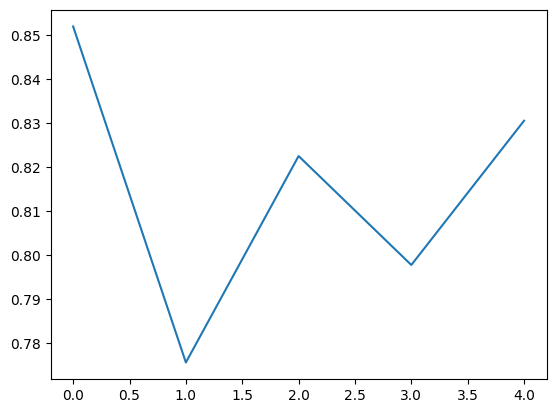

In [45]:
# Plot the performance
import matplotlib.pyplot as plt

split = 'seed42_tr29'
part = ov_all_ckpts[(ov_all_ckpts['model'] == 'llama3')
                    & (ov_all_ckpts['split'] == split)]
step_pfm = []
for _, row in part.iterrows():
    ckpt = int(row['ckpt'].split('-')[-1])
    rep_m = row['res_ov']['macro_p']
    step_pfm.append((ckpt, rep_m))
step_pfm.sort(key = lambda k: k[0])

plt.plot([k[1] for k in step_pfm])